<a href="https://colab.research.google.com/github/Braafisch/ASD-Assignments/blob/main/asd_assignment4/asd_assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vorlesung Automones Fahren, HS Esslingen, Thao Dang

# Robuste Spurverlaufsschätzung mit RANSAC und M-Estimatoren

## Vorbereitungen

Nachdem Sie in der letzten Übung Spurparameter mit Hilfe eines Least-Squares(LS)-Schätzers bestimmt haben, werden Sie in dieser Übung zwei robuste LS-Schätzer implementieren: RANSAC und M-Estimatoren.

Laden der Standard-Bibliotheken:

In [14]:
import cv2
import numpy as np
import random
import requests
import shutil
from matplotlib import pyplot as plt
%matplotlib inline

In der letzten Übung wurden Ihnen Punkte der linken und rechten Fahrbanmarkierungen als zwei separate Arrays vorgegeben. In der Realität ist aber a priori nicht einfach zu entscheiden, welche Kantenpunkte im Bild zu welcher Markierung gehören (bzw. ob Kantenpunkte überhaupt Teil einer Markierung sind): 

![markings](https://drive.google.com/uc?id=1UPhB_8l_5rOqDUWv5xluQrzx5fpTIPY1)

In dieser Übung arbeiten Sie auf den nicht vorsortierten Markierungspunkten, die im Folgenden geladen werden.

In [2]:
# Upload data - Colab ONLY!
# pts_left_full.npy, pts_right_full.npy
try: 
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

except:
    print('Not using Colab or error uploading files.')

Saving pts_all.npy to pts_all.npy
User uploaded file "pts_all.npy" with length 9376 bytes


In [18]:
# Upload data - Colab ONLY!
# pts_left_full.npy, pts_right_full.npy

url = 'https://raw.githubusercontent.com/Braafisch/ASD-Assignments/main/asd_assignment4/pts_all.npy'
response = requests.get(url, allow_redirects = True, stream = True).raw

with open('pts_all.npy', 'wb') as fin:
    shutil.copyfileobj(response, fin)

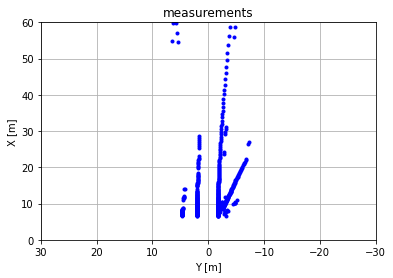

In [19]:
M = np.load('pts_all.npy')

plt.title('measurements')
plt.plot(M[:, 1], M[:, 0], 'b.')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);

## 1. RANSAC

Für die weiteren Schritte ist es wichtig zu unterscheiden, welche Punkte in ``M`` zum linken bzw. zum rechten Rand der Fahrspur gehören. Dies ist wie bereits beschrieben keine einfache Aufgabe, insbesondere wenn kein Vorwissen (z.B. aus dem vorangehenden Zeitschritt) gegeben ist. 

Wir verwenden hier einen einfachen Ansatz, bei dem wir einfach zwei Regions-Of-Interest (ROIs) für den linken und rechten Fahrspurrand definieren: 
![roi_left_right](https://drive.google.com/uc?id=1QccXcCXa696_90lRdCl8wnIZhjcpaIWP)

Diese Einteilung ist sicher nicht fehlerfrei und es kann sogar vorkommen, dass der gleiche Messpunkt sowohl dem linken als auch dem rechten Fahrspurrand zugeordnet werden. Da wir  aber einen robusten Schätzer verwenden werden, können wir später solche fehlerhaften Zuordnungen erkennen und verwerfen.

Hier der Code für die Aufteilung in linke und rechte Berandungspunkte ``lane_left`` und ``lane_right``, basierend auf der bereits bekannten Funktion ``cv2.pointPolygonTest``:

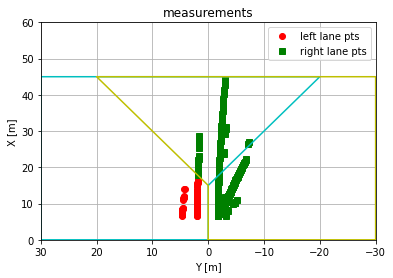

In [4]:
max_range_m = 45
roi_right_line = np.array([
    [0, 0], 
    [15, 0], 
    [max_range_m, 20], 
    [max_range_m, -30], 
    [0, -30] ])

roi_left_line = np.array([
    [0, 0], 
    [15, 0], 
    [max_range_m, -20], 
    [max_range_m, 30], 
    [0, 30] ])

lane_left = np.empty((0,2))
lane_right = np.empty((0,2))

for i in range(M.shape[0]):
    if cv2.pointPolygonTest(roi_left_line, (M[i,0], M[i,1]), False) > 0:
        lane_left = np.vstack((lane_left, M[i,:])) 
    if cv2.pointPolygonTest(roi_right_line, (M[i,0], M[i,1]), False) > 0:
        lane_right = np.vstack((lane_right, M[i,:])) 
        
plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'ro', label='left lane pts')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'gs', label='right lane pts')
plt.legend()
plt.plot(roi_left_line[np.r_[0:roi_left_line.shape[0], 0], 1], 
         roi_left_line[np.r_[0:roi_left_line.shape[0], 0], 0], 'c')
plt.plot(roi_right_line[np.r_[0:roi_right_line.shape[0], 0], 1], 
         roi_right_line[np.r_[0:roi_right_line.shape[0], 0], 0], 'y')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);

In der letzten Übung wurden Ihnen die Formeln für das Messmodell in Abhängigkeit des Parametervektors

\begin{equation}
\mathbf{z} = \left[ W, Y_{\mbox{offset}}, \Delta \phi, c_0 \right]^T, \tag{1}
\end{equation}

vorgestellt. Sie benötigen in dieser Übung dieselben Gleichungen. Die Funktionen zur einfachen LS-Schätzung und Darstellung der Spur aus der letzten Übung sind schon vorgegeben. Koordinatenangaben sind jeweils in DIN70000.

In [5]:
def LS_lane_fit(pL, pR):
    """
    LS estimate for lane coeffients z=(W, Y_offset, Delta_Phi, c0)^T.
    
    Args:
        pL: [NL, 2]-array of left marking positions (in DIN70000) 
        pR: [NR, 2]-array of right marking positions (in DIN70000)
    
    Returns:
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
    """
    
    H = np.zeros((pL.shape[0]+pR.shape[0], 4)) # design matrix
    Y = np.zeros((pL.shape[0]+pR.shape[0], 1)) # noisy observations
    
    # fill H and Y for left line points
    for i in range(pL.shape[0]):
        u, v = pL[i,0], pL[i,1]
        u2 = u*u
        H[i, :] = [0.5, -1, -u, 1.0/2.0 * u2]
        Y[i] = v

    # fill H and Y for right line points
    for i in range(pR.shape[0]):
        u, v = pR[i,0], pR[i,1]
        u2 = u*u
        u3 = u2*u 
        H[pL.shape[0]+i, :] = [-0.5, -1, -u, 1.0/2.0 * u2]
        Y[pL.shape[0]+i] = v

    # compute optimal state vector Z
    Z = np.dot(np.linalg.pinv(H), Y)
    
    return Z


def LS_lane_compute(Z, maxDist=60, step=0.5):
    """
    Compute lane points from given parameter vector.
    
    Args;
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
        maxDist[=60]: distance up to which lane shall be computed
        step[=0.5]: step size in x-direction (in m)
       
    Returns:
        (x_pred, yl_pred, yr_pred): x- and y-positions of left and 
            right lane points
    """
    x_pred = np.arange(0, maxDist, step)
    yl_pred = np.zeros_like(x_pred)
    yr_pred = np.zeros_like(x_pred)

    for i in range(x_pred.shape[0]):
        u = x_pred[i]
        u2 = u*u
        yl_pred[i] = np.dot( np.array([ 0.5, -1, -u, 1.0/2.0 * u2]), Z )
        yr_pred[i] = np.dot( np.array([-0.5, -1, -u, 1.0/2.0 * u2]), Z )
    
    return (x_pred, yl_pred, yr_pred)

Damit können wir eine erste LS-Schätzung durchführen:

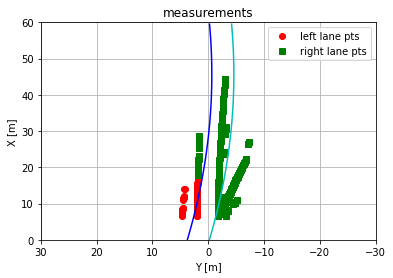

In [6]:
Z_all = LS_lane_fit(lane_left, lane_right)
x_pred, yl_pred, yr_pred = LS_lane_compute(Z_all)
    
plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'ro', label='left lane pts')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'gs', label='right lane pts')
plt.legend()
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);

Das Ergebnis ist nicht befriedigend! Grund hierfür ist, dass sich grobe Ausreißer in den Messdaten befinden: nicht alle Punkte in ``lane_left`` gehören zur linken Berandung und nicht alle Punkte in ``lane_right`` zur rechten Berandung. 

Da aber die Kleinsten-Quadrate-Schätzung einen Ausgleich über **alle** vorhandenen Messungen herstellt, erhalten wir ein unbrauchbares Ergebnis. Ein Lösungsansatz für dieses Problem sind robuste Schätzer.

### A1.1

Für das in der Vorlesung beschriebene RANSAC Verfahren ist die Bestimmung von Ausreißern (engl. outlier) von zentraler Bedeutung: Beim RANSAC Verfahren ist diejenige Schätzung die beste, für welche die Anzahl der __Outlier__ minimal ist bzw. die Anzahl der __Inlier__ maximal.

Um zu entscheiden, ob eine Messung ein inlier oder ein outlier ist, werden die sog. Residuen $r$ der Schätzung bestimmt. Residuen sind die Abstände der tatsächlichen gemessenen Größe (in unserem Fall der Querversatz Y_L oder Y_R) zun den erwarteten Messgrößen bei gegebenem Parametervektor $\mathbf{Z}$ (hier der erwartete Querversatz entsprechend Gln. (2) und (3) der letzten Übung bei gegebenem $X_L$ bzw $X_R$). 

Ist ein solches Residuum betragsmäßig kleiner als eine gegebene Schwelle: $|r| < thresh$, handelt es sich um einen Inlier.

Vervollständigen Sie zur Bestimmung der Inlier die beiden unten angeführten Funktionen
``LS_lane_residuals(lane_left, lane_right, Z)`` zur Berechnung des Residuenvektors $r$ und 
``LS_lane_inliers(residual, thresh)`` zur Bestimmung der Anzahl an Inliern. 

In [7]:
print(lane_left[:,0].shape[0])

240


In [8]:
def create_H(x_lane_left,x_lane_rigth):
  length_left = x_lane_left.shape[0]
  length_rigth = x_lane_rigth.shape[0]
  H = np.zeros((length_left + length_rigth, 4))

  H[:, 0] = np.append(np.full(x_lane_left.shape, 0.5), np.full(x_lane_rigth.shape, -0.5), axis= 0)
  H[:, 1] = np.full(H.shape[0], -1)
  H[:, 2] = -np.append(x_lane_left, x_lane_rigth, axis= 0)
  H[:, 3] = 0.5*np.append(x_lane_left, x_lane_rigth, axis= 0)**2
  return H

In [9]:
def LS_lane_residuals(lane_left, lane_right, Z):
    
    
    ## HIER CODE EINFUEGEN
    H = create_H(lane_left[:,0], lane_right[:,0])
    yl_pred = np.dot(H, Z)
    residual = np.absolute(yl_pred[:,0] - np.append(lane_left[:,1], lane_right[:,1]))
    ## EIGENER CODE ENDE

    return residual


def LS_lane_inliers(residual, thresh):
    
    ## HIER CODE EINFUEGEN
    return len(residual[residual <= thresh])
    ## EIGENER CODE ENDE
    
    
# test with previous estimate
residual = LS_lane_residuals(lane_left, lane_right, Z_all)
#print(residual)
print('Found %d inliers (of %d total points).' % 
      (LS_lane_inliers(residual, 0.4), lane_left.shape[0]+lane_right.shape[0]))

Found 172 inliers (of 565 total points).


### A1.2

Mit diesen Funktionen kann schliesslich der RANSAC Schätzer für die Spurparameter implementiert werden. Orientieren Sie sich dazu an den Vorlesungsfolien.

Bestimmen Sie experimentell eine "gute" Anzahl von Iterationen, um ein zufriedenstellendes Ergebnis zu erhalten.

Current best solution:  [[ 3.77354116e+00 -1.14800222e-01 -1.72070234e-02 -2.70043148e-03]]
with 310 inliers (of 565 measurements).


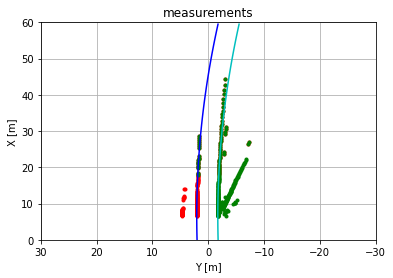

In [10]:
# RANSAC
S = 4
dist_thresh = 0.4
max_num_inliers = 0
Z_opt = None
num_iters = 50

for i in range(num_iters):
    # draw S//2 random indices for points in lane_left and lane_right, respectively
    idx_left = random.sample(range(lane_left.shape[0]), S//2) 
    idx_right = random.sample(range(lane_right.shape[0]), S//2)

    ## HIER CODE EINFUEGEN
    Z = LS_lane_fit(lane_left[idx_left], lane_right[idx_right])
    residual = LS_lane_residuals(lane_left, lane_right, Z)
    inliers = LS_lane_inliers(residual, dist_thresh)
    if inliers > max_num_inliers:
      Z_opt = Z
      max_num_inliers = inliers
    ## EIGENER CODE ENDE

    
x_pred, yl_pred, yr_pred = LS_lane_compute(Z_opt)
print("Current best solution: ", Z_opt.T)
print("with %d inliers (of %d measurements)." % (max_num_inliers, lane_left.shape[0]+lane_right.shape[0]))


plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'r.')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'g.')
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);

## 2. M-Estimator

Eine etwas schnellere Methode zur Bestimmung der Spurparameter, die allerdings eine vernünftige Anfangsschätzung (z.B. aus dem vorangehenden Zeitschritt) erfordert, ist die Verwendung von M-Estimatoren. Diese sind in den Vorlesungsfolien beschrieben.

### A2.1

Als Gewichtsfunktion für den M-Estimator verwenden wir hier eine Cauchy-Funktion:

$$
w_i = \frac{1}{1+\left( \frac{r_i}{c} \right)^2}
$$

Hierbei bezeichnet
* $r_i$ die $i$-te Komponente des Residuenvektors,
* $w_i$ das resultierende Gewicht für diese Komponente, 
* $c = 2.3849 \sigma$ eine Skalierungskonstante und
* $\sigma$ die erwartete Standardabweichung der Messfehler der Inlier.

Implementieren Sie die Cauchy-Funkction für einen gegebenen Residuenvektor.

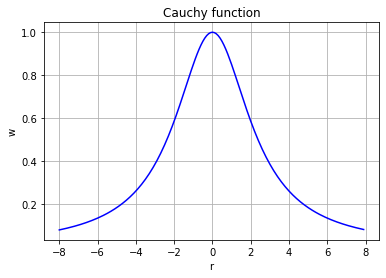

In [18]:
def Cauchy(r, sigma=1):
    """
    Cauchy loss function.
    
    Args:
        r: resiudals
        sigma: expected standard deviation of inliers
        
    Returns:
        w: vector of weight coefficients
    """
    ## HIER CODE EINFUEGEN
    c = 2.3849*sigma
    return 1 / (1 + (r/c)**2)
    ## EIGENER CODE ENDE
    

# test Cauchy function
r = np.arange(-8,8,0.1)
plt.plot(r, Cauchy(r), 'b')
plt.title('Cauchy function')
plt.xlabel('r')
plt.ylabel('w')
plt.grid(True);

### A2.2

Verwenden Sie die oben beschriebene Gewichtsfunktion, um einen M-Estimator wie in der Vorlesung besprochen zu implementieren. 

Untersuchen Sie dabei verschiedene Parameter für die maximale Anzahl an Iterationen und für unterschiedliche Standardabweichungen $\sigma$ der Inlier.

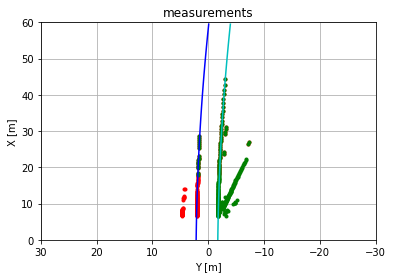

In [67]:
def MEstimator_lane_fit(pL, pR, Z_initial, sigma=1, maxIteration=10):
    """
    M-Estimator for lane coeffients z=(W, Y_offset, Delta_Phi, c0)^T.
    
    Args:
        pL: [NL, 2]-array of left marking positions (in DIN70000) 
        pR: [NR, 2]-array of right marking positions (in DIN70000)
        Z_initial: the initial guess of the parameter vector
        sigma: the expecvted standard deviation of the inliers
        maxIteration: max number of iterations
    
    Returns:
        Z: lane coeffients (W, Y_offset, Delta_Phi, c0)
    """
    
    H = np.zeros((pL.shape[0]+pR.shape[0], 4)) # design matrix
    Y = np.zeros((pL.shape[0]+pR.shape[0], 1)) # noisy observations
    
    # fill H and Y for left line points
    for i in range(pL.shape[0]):
        u, v = pL[i,0], pL[i,1]
        u2 = u*u
        H[i, :] = [0.5, -1, -u, 1.0/2.0 * u2]
        Y[i] = v

    # fill H and Y for right line points
    for i in range(pR.shape[0]):
        u, v = pR[i,0], pR[i,1]
        u2 = u*u
        u3 = u2*u 
        H[pL.shape[0]+i, :] = [-0.5, -1, -u, 1.0/2.0 * u2]
        Y[pL.shape[0]+i] = v
        
    ## HIER CODE EINFUEGEN
    for _ in range(maxIteration):
      r = np.dot(H, np.asarray(Z_initial).reshape(4,1)) - Y
      assert r.shape == (H.shape[0], 1)
      w = Cauchy(r, sigma)
      assert w.shape == r.shape
      W = np.diag(w[:,0])
      assert W.shape == (w.shape[0], w.shape[0])
      Z = np.linalg.multi_dot([np.linalg.inv(np.linalg.multi_dot([H.T, W, H])), H.T, W, Y])
      assert Z.shape == (4, 1)
      Z_initial = Z 
    ## EIGENER CODE ENDE
    
    return Z


# initial estimate: straight road 
Z_initial = np.array([4, -2, 0, 0]).T 

# refine initial estimate via M-Estimator
Z_MEst = MEstimator_lane_fit(lane_left, lane_right, Z_initial, 
                             sigma=0.2, maxIteration=10)

# draw result
x_pred, yl_pred, yr_pred = LS_lane_compute(Z_MEst)
plt.title('measurements')
plt.plot(lane_left[:, 1], lane_left[:, 0], 'r.')
plt.plot(lane_right[:, 1], lane_right[:, 0], 'g.')
plt.plot(yl_pred, x_pred, 'b')
plt.plot(yr_pred, x_pred, 'c')
plt.xlim(30, -30)
plt.xlabel('Y [m]')
plt.ylim(0, 60)
plt.ylabel('X [m]')
plt.grid(True);